In [1]:
from weaPoints import WeaPoints, InterpolationMethod, WindDataType
from anemosData import TsNcWindData, WindDataKind
import numpy as np
import xarray
import pandas

# Loading Points

In [2]:
size = 150
lon = np.around(np.random.uniform(6.0, 14.0, size=size),5)
lat = np.around(np.random.uniform(48.0, 55.0, size=size),5)
lat_lon_coor = np.stack((lat, lon), axis=1)
level = np.around(np.random.uniform(120.0, 120.0, size=size),1)

testPoints = WeaPoints(
    lat_lon_coor = lat_lon_coor,
    level = level,
    wea_types = ["test_wea"] * size,
    #interpolation_method = [InterpolationMethod.LINEAR] * size,
    _interpolated_power_curves = True,
)

testPoints.point_list[:5]

[_WeaPoint(lat_lon_coor=array([51.17501,  9.70198]), level=136.3, wea_type='test_wea', x_y_coor=[-71972.3166045506, 31815.154717120688]),
 _WeaPoint(lat_lon_coor=array([52.4137 , 11.12735]), level=128.7, wea_type='test_wea', x_y_coor=[26510.017927067063, 168921.15214421856]),
 _WeaPoint(lat_lon_coor=array([50.83767, 12.36408]), level=133.0, wea_type='test_wea', x_y_coor=[114143.37883037147, -4882.105997918228]),
 _WeaPoint(lat_lon_coor=array([49.26877,  6.6075 ]), level=127.1, wea_type='test_wea', x_y_coor=[-299073.1649200656, -171981.05116332747]),
 _WeaPoint(lat_lon_coor=array([49.62198,  8.81686]), level=121.9, wea_type='test_wea', x_y_coor=[-138060.13960797398, -139332.8987455991])]

# Get Time series

### 15 min TSnetCDF

Passed time_frame valid.
TSnetCDF data loaded.
Time period loaded.
Windpower turbine 1 complete
Windpower turbine 2 complete
Windpower turbine 3 complete
Windpower turbine 4 complete
Windpower turbine 5 complete
Windpower turbine 6 complete
Windpower turbine 7 complete
Windpower turbine 8 complete
Windpower turbine 9 complete
Windpower turbine 10 complete
Windpower turbine 11 complete
Windpower turbine 12 complete
Windpower turbine 13 complete
Windpower turbine 14 complete
Windpower turbine 15 complete
Windpower turbine 16 complete
Windpower turbine 17 complete
Windpower turbine 18 complete
Windpower turbine 19 complete
Windpower turbine 20 complete
Windpower turbine 21 complete
Windpower turbine 22 complete
Windpower turbine 23 complete
Windpower turbine 24 complete
Windpower turbine 25 complete
Windpower turbine 26 complete
Windpower turbine 27 complete
Windpower turbine 28 complete
Windpower turbine 29 complete
Windpower turbine 30 complete
Windpower turbine 31 complete
Windpower tu

<AxesSubplot:>

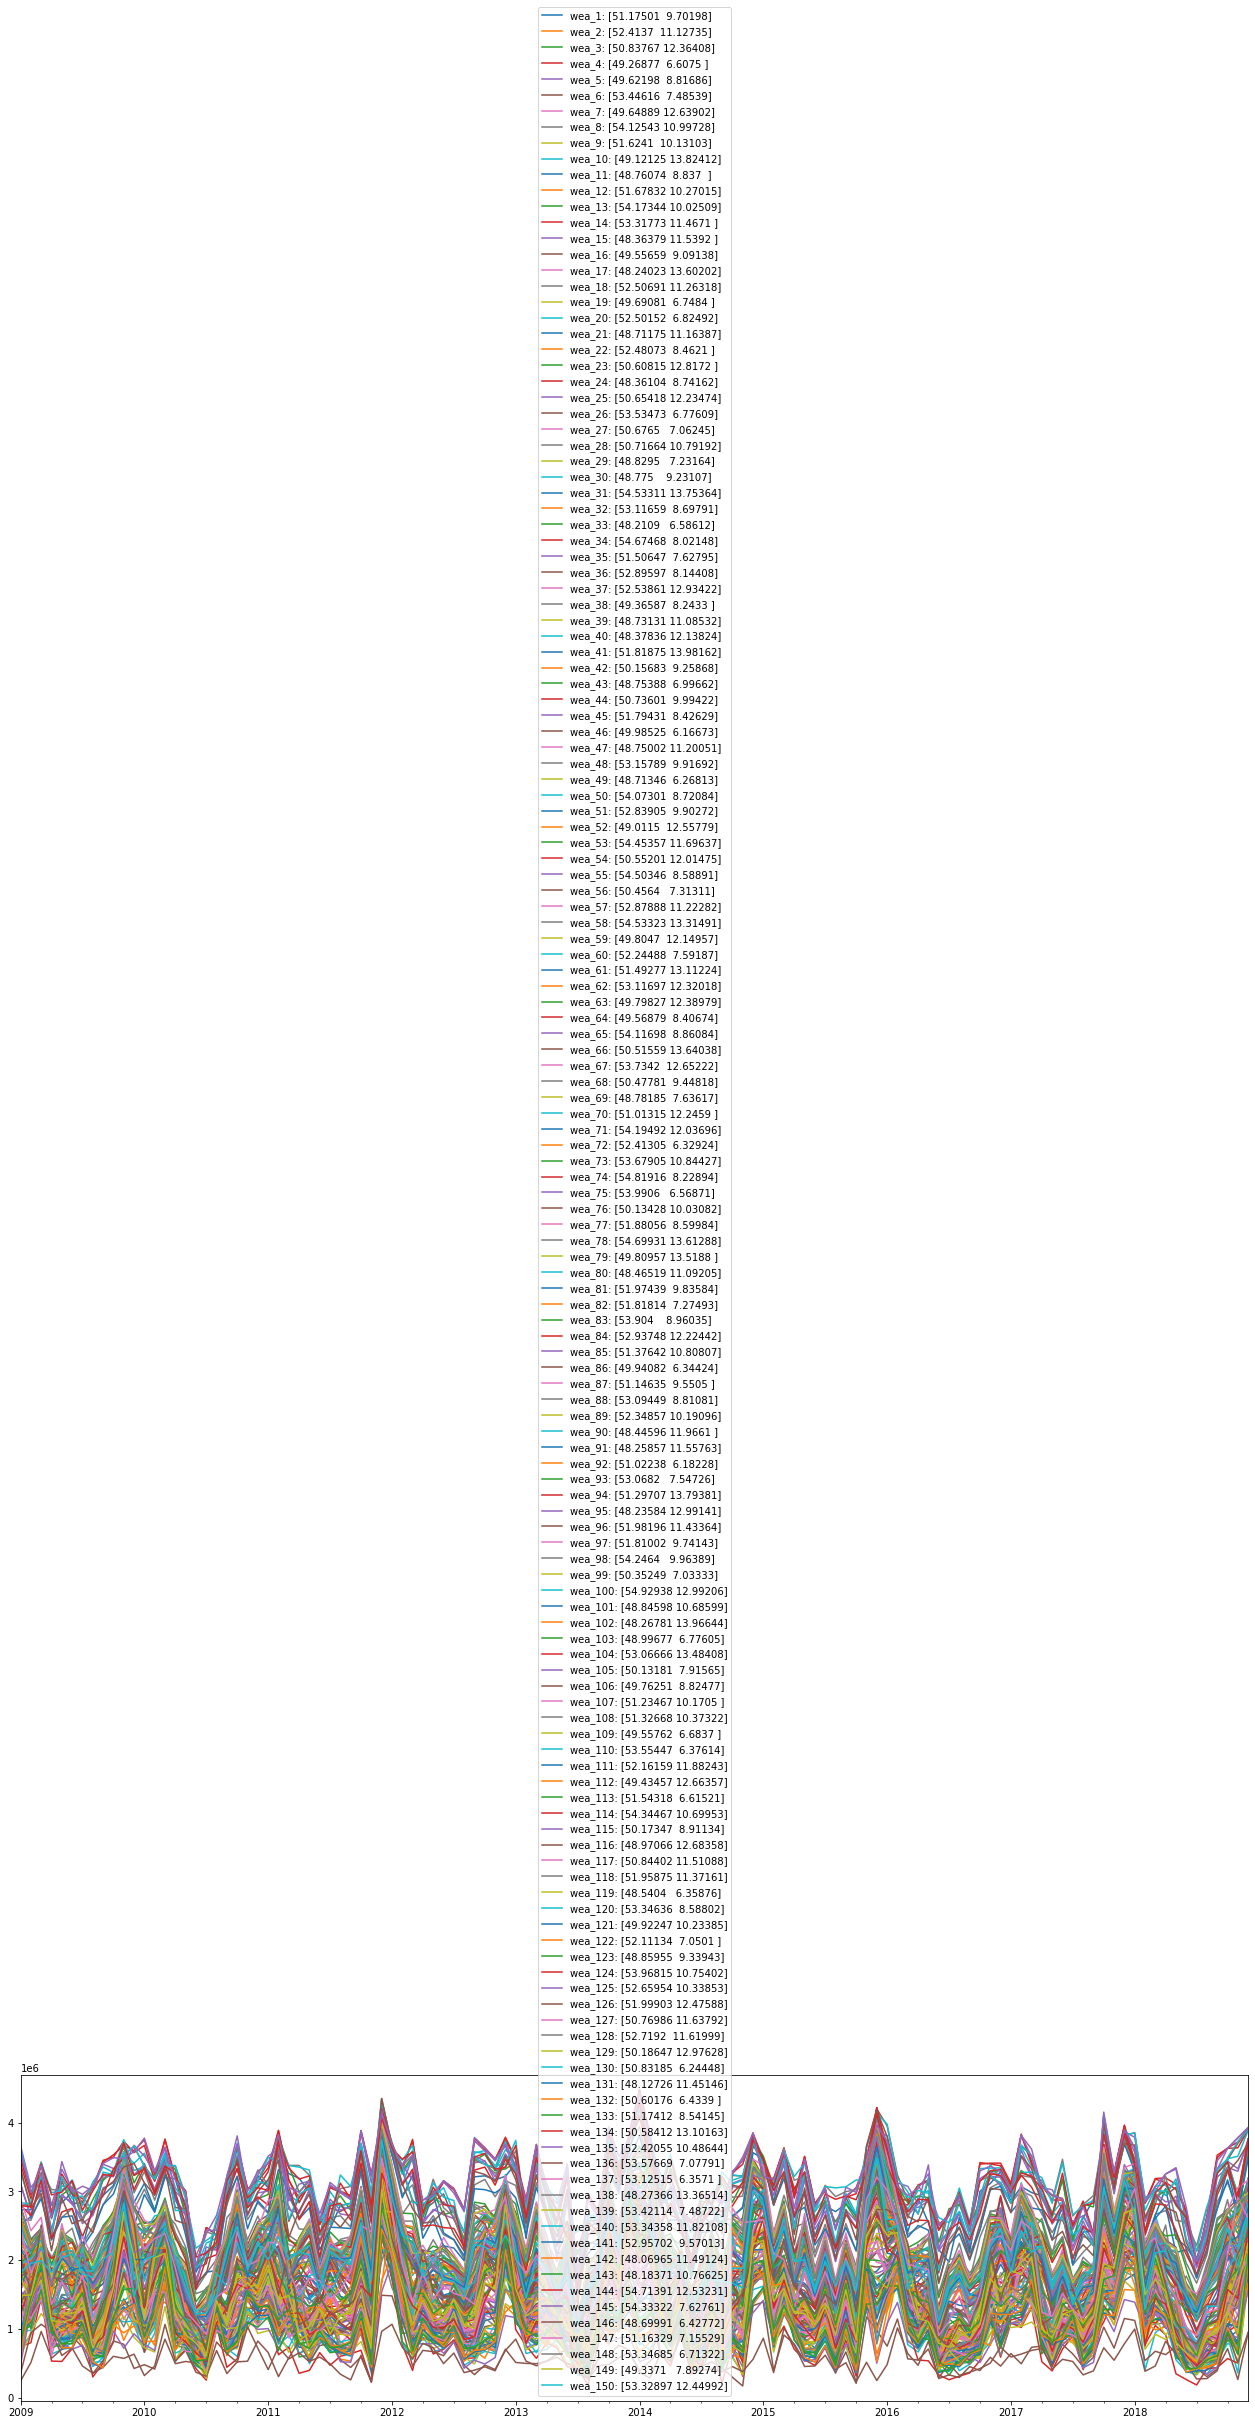

In [3]:
testPoints.get_windpower_out(wind_data_type=WindDataType.TSNETCDF, time_frame=[2009,"2018-12-31"])

Eout = {}
for num, point in enumerate(testPoints.point_list):
    Eout[f"wea_{num+1}: {point.lat_lon_coor}"] = point.power_time_series

df = pandas.DataFrame(data=Eout,index=testPoints.time_periode)

df.resample("1m").sum().plot(figsize=(22,6))

<AxesSubplot:>

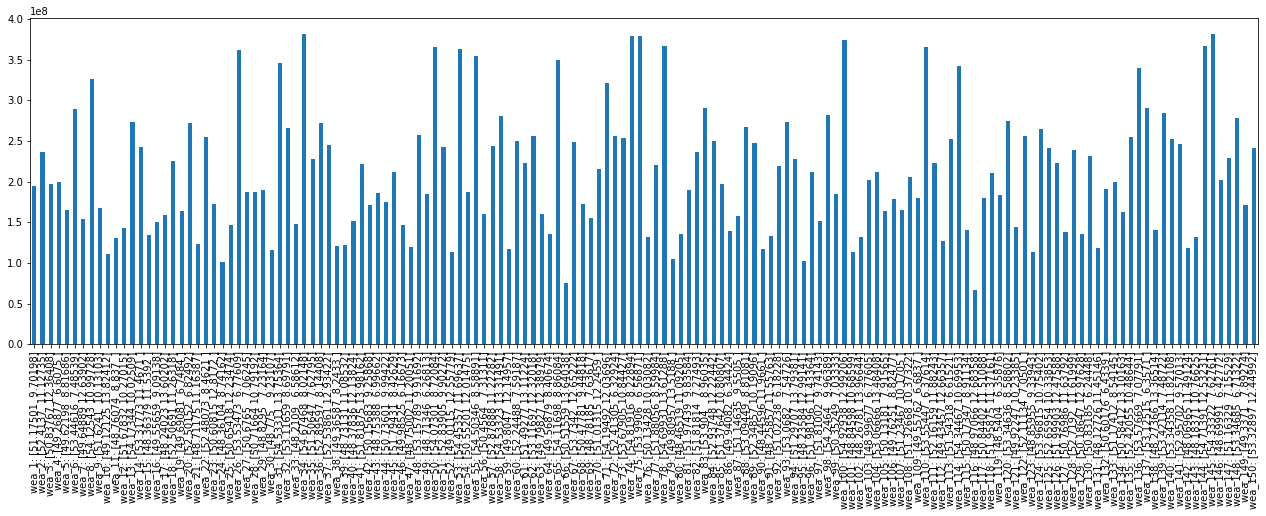

In [4]:
df.sum(axis=0).plot.bar(figsize=(22,6))

### 90m Mean

Passed time_frame valid.
mean90m data loaded.
Windpower turbine 1 complete
Windpower turbine 2 complete
Windpower turbine 3 complete
Windpower turbine 4 complete
Windpower turbine 5 complete
Windpower turbine 6 complete
Windpower turbine 7 complete
Windpower turbine 8 complete
Windpower turbine 9 complete
Windpower turbine 10 complete
Windpower turbine 11 complete
Windpower turbine 12 complete
Windpower turbine 13 complete
Windpower turbine 14 complete
Windpower turbine 15 complete
Windpower turbine 16 complete
Windpower turbine 17 complete
Windpower turbine 18 complete
Windpower turbine 19 complete
Windpower turbine 20 complete
Windpower turbine 21 complete
Windpower turbine 22 complete
Windpower turbine 23 complete
Windpower turbine 24 complete
Windpower turbine 25 complete
Windpower turbine 26 complete
Windpower turbine 27 complete
Windpower turbine 28 complete
Windpower turbine 29 complete
Windpower turbine 30 complete
Windpower turbine 31 complete
Windpower turbine 32 complete
Win

<AxesSubplot:>

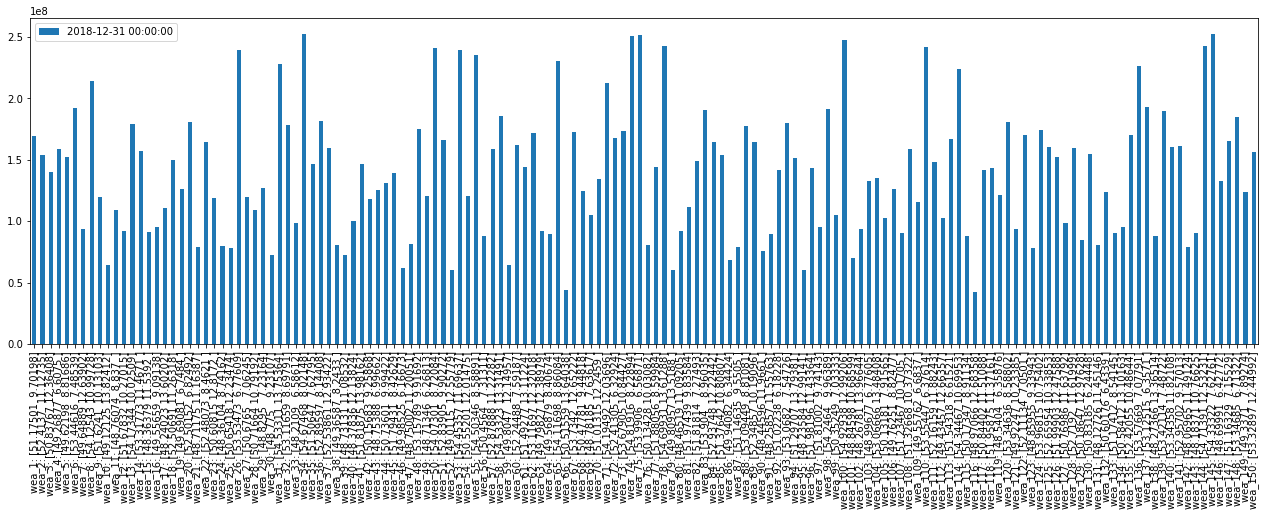

In [5]:
testPoints.get_windpower_out(wind_data_type=WindDataType.MEAN90M)
Eout = {}
for num, point in enumerate(testPoints.point_list):
    Eout[f"wea_{num+1}: {point.lat_lon_coor}"] = point.power_time_series

df_90mean = pandas.DataFrame(data=Eout,index=testPoints.time_periode)
df_90mean.head()#.resample("14d").mean().plot(figsize=(22,6))

df_90mean.transpose().plot.bar(figsize=(22,6))

### Comparison

Text(0, 0.5, '10-Jahresertrag in TWh')

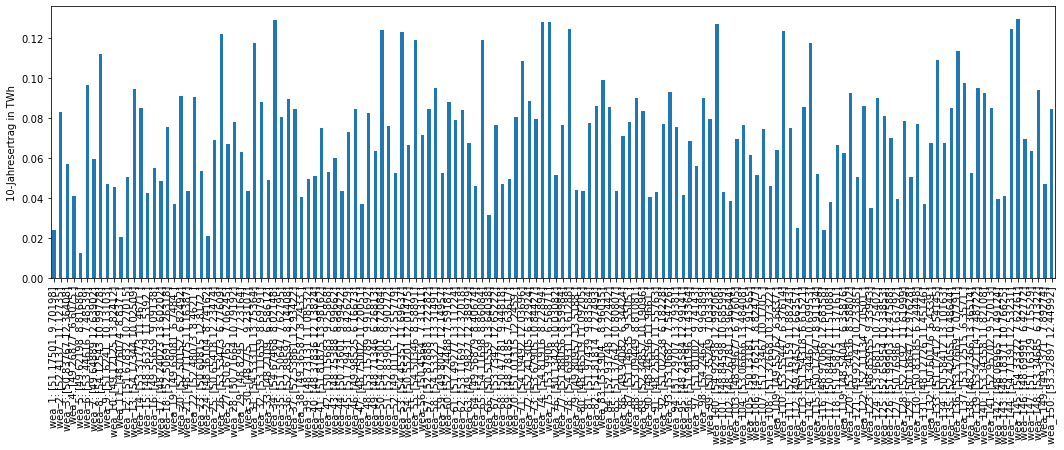

In [48]:
from datetime import datetime

comp = df_90mean.transpose()
comp["15min"] = df.sum(axis=0)
comp.columns = [i.strftime('%Y-%m-%d') if isinstance(i, datetime) else i for i in comp.columns]
comp = comp.rename(columns={comp.columns[0]:"wiebull_90m"})
comp = comp / 1000000000 # Wh zu TWh umrechnen
comp["diff"] = comp["15min"] - comp["wiebull_90m"]

ax = comp["diff"].plot.bar(figsize=(18,5))
ax.set_ylabel("10-Jahresertrag in TWh")

In [29]:
import geopandas
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as cx

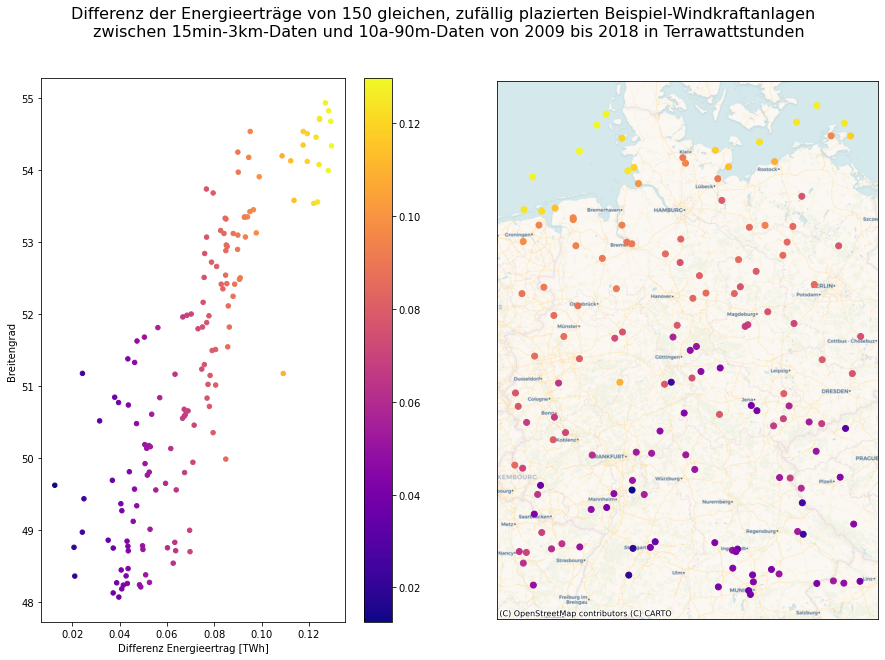

In [64]:
points = [point.lat_lon_coor for point in testPoints.point_list]
lat = [point[0] for point in points]
lon = [point[1] for point in points]

geodf = geopandas.GeoDataFrame(
    comp, geometry=geopandas.points_from_xy(lon, lat))

geodf["y"] = geodf.geometry.y
geodf["x"] = geodf.geometry.x

geodf = geodf.sort_values(by='y', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle("Differenz der Energieerträge von 150 gleichen, zufällig plazierten Beispiel-Windkraftanlagen \n zwischen 15min-3km-Daten und 10a-90m-Daten von 2009 bis 2018 in Terrawattstunden", fontsize=16)
# SCATTER
geodf.plot(kind="scatter", x="diff", y="y", ax=ax[0], c=geodf["diff"], cmap='plasma')
ax[0].set_ylabel("Breitengrad")
ax[0].set_xlabel("Differenz Energieertrag [TWh]")

# MAP
geodf.crs = "EPSG:4326"
geodf = geodf.to_crs(epsg=3857)

geodf.plot(column='diff', ax=ax[1], cmap='plasma')#, cax=cax)
cx.add_basemap(ax[1], source=cx.providers.CartoDB.Voyager)#, crs=geodf.crs)
ax[1].set_xticks([])
ax[1].set_yticks([])

fig.savefig('Diff150Anlagen.eps', format='eps')

### 3km man

In [8]:
path = "/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/Statistics/10-Jahresmittel/histos.120m.2009-2018.nc"


xarray.open_dataset(path).interp(x=12.3,y=30.34).wbk

<xarray.DataArray 'wbk' ()>
array(2.21624273)
Coordinates:
    x        float64 12.3
    y        float64 30.34
Attributes:
    description:  Weibull k
    units:        -

In [9]:
path = "/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/3arcsecs/D-3km.E5.3arcsecs.wbk.2009-2018.nc"

xarray.open_dataset(path, engine="h5netcdf").interp(x=6.27371826,y=47.94883789, level=120).wbk

<xarray.DataArray 'wbk' ()>
array(2.21623352)
Coordinates:
    x        float64 6.274
    y        float64 47.95
    level    int64 120
Attributes:
    grid_mapping:  spatial_ref